#  Modelagem Preditiva – Obesidade (Classificação Binária)

Este notebook tem como objetivo construir, treinar e avaliar modelos de Machine Learning
para a previsão de obesidade, utilizando uma abordagem de classificação binária.
Serão comparados três modelos: Regressão Logística (baseline), Random Forest e XGBoost.
Ao final, será selecionado o modelo com melhor desempenho para ser utilizado no pipeline
final e no sistema preditivo (Streamlit).

## Importações de bibliotecas e configurações

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from xgboost import XGBClassifier

RANDOM_STATE = 42
sns.set(style="whitegrid")

## Carregamento do dataset

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/RickPardono/TechChallenge4_Fiap/refs/heads/main/data/raw/Obesity.csv")
df.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## Criação do target binário (Obeso vs Não obeso)

In [3]:
obese_classes = ["Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"]

df["ObeseBinary"] = df["Obesity"].apply(lambda x: 1 if x in obese_classes else 0)

In [4]:
df["ObeseBinary"].value_counts(), df["ObeseBinary"].value_counts(normalize=True).round(4)

(ObeseBinary
 0    1139
 1     972
 Name: count, dtype: int64,
 ObeseBinary
 0    0.5396
 1    0.4604
 Name: proportion, dtype: float64)

## Separação de features e target

In [5]:
X = df.drop(columns=["Obesity", "ObeseBinary"])
y = df["ObeseBinary"]

## Split treino/teste

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

## Definição das colunas por tipo (numéricas, binárias, ordinais, nominais)

* Numéricas contínuas: Age, Height, Weight

* Binárias (yes/no): family_history, FAVC, SMOKE, SCC

* Ordinais numéricas com ruído: FCVC, NCP, CH2O, FAF, TUE (serão arredondadas via transformer simples)

* Ordinais textuais: CAEC, CALC (ordem natural)

* Nominal: Gender, MTRANS (OneHot)







In [7]:
num_cols = ["Age", "Height", "Weight"]

bin_cols = ["family_history", "FAVC", "SMOKE", "SCC"]

ordinal_num_cols = ["FCVC", "NCP", "CH2O", "FAF", "TUE"]

ordinal_text_cols = ["CAEC", "CALC"]

nominal_cols = ["Gender", "MTRANS"]

## Pré-processamento com ColumnTransformer

### Pipeline numérico (impute + scaler)

In [8]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

### Pipeline binário (impute + onehot "drop if binary")

In [9]:
binary_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="if_binary", handle_unknown="ignore"))
])

### Pipeline ordinal numérica (arredondar + impute + passthrough/encoder)

In [10]:
def round_ordinal_cols(X):
    X = X.copy()
    return np.rint(X).astype(int)

ordinal_num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("round", FunctionTransformer(round_ordinal_cols, feature_names_out="one-to-one")),
])

### Pipeline ordinal textual (impute + OrdinalEncoder com ordem definida)

In [11]:
caec_order = ["no", "Sometimes", "Frequently", "Always"]
calc_order = ["no", "Sometimes", "Frequently", "Always"]

ordinal_text_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(categories=[caec_order, calc_order]))
])

### Pipeline nominal (impute + OneHot)

In [12]:
nominal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

### ColumnTransformer final

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("bin", binary_transformer, bin_cols),
        ("ord_num", ordinal_num_transformer, ordinal_num_cols),
        ("ord_txt", ordinal_text_transformer, ordinal_text_cols),
        ("nom", nominal_transformer, nominal_cols),
    ],
    remainder="drop"
)

## Função de avaliação do modelo

In [14]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"=== {model_name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.title(f"Matriz de Confusão - {model_name}")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

    return {"Model": model_name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}

## Treinar e avaliar 3 modelos (LR, RF, XGBoost)

### Regressão Logística (baseline)

=== Logistic Regression ===
Accuracy : 0.9953
Precision: 0.9949
Recall   : 0.9949
F1-score : 0.9949

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       228
           1       0.99      0.99      0.99       195

    accuracy                           1.00       423
   macro avg       1.00      1.00      1.00       423
weighted avg       1.00      1.00      1.00       423



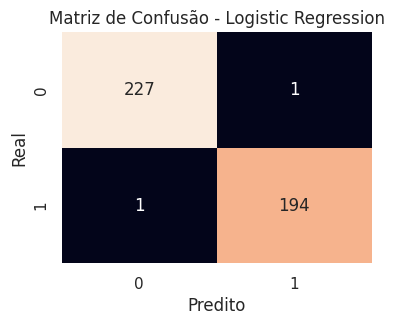

In [15]:
lr = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)

lr_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", lr)
])

lr_model.fit(X_train, y_train)
lr_metrics = evaluate_model(lr_model, X_test, y_test, "Logistic Regression")

### Random Forest

=== Random Forest ===
Accuracy : 0.9811
Precision: 0.9795
Recall   : 0.9795
F1-score : 0.9795

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       228
           1       0.98      0.98      0.98       195

    accuracy                           0.98       423
   macro avg       0.98      0.98      0.98       423
weighted avg       0.98      0.98      0.98       423



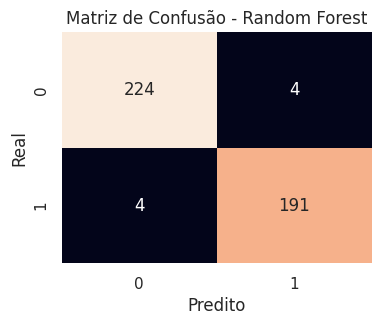

In [16]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", rf)
])

rf_model.fit(X_train, y_train)
rf_metrics = evaluate_model(rf_model, X_test, y_test, "Random Forest")


### XGBoost

=== XGBoost ===
Accuracy : 0.9953
Precision: 0.9949
Recall   : 0.9949
F1-score : 0.9949

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       228
           1       0.99      0.99      0.99       195

    accuracy                           1.00       423
   macro avg       1.00      1.00      1.00       423
weighted avg       1.00      1.00      1.00       423



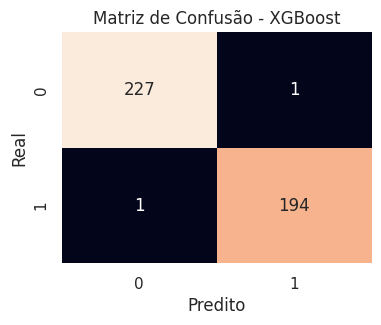

In [17]:
xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=RANDOM_STATE,
    eval_metric="logloss",
    n_jobs=-1
)

xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", xgb)
])

xgb_model.fit(X_train, y_train)
xgb_metrics = evaluate_model(xgb_model, X_test, y_test, "XGBoost")

## Comparação final dos modelos (tabela)

In [18]:
results = pd.DataFrame([lr_metrics, rf_metrics, xgb_metrics])
results.sort_values(by="F1", ascending=False)

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.995272,0.994872,0.994872,0.994872
2,XGBoost,0.995272,0.994872,0.994872,0.994872
1,Random Forest,0.981087,0.979487,0.979487,0.979487


## ## Otimização do Modelo Selecionado (Regressão Logística)

Embora a Regressão Logística já tenha apresentado excelente desempenho, será realizada uma
validação cruzada estratificada com GridSearchCV (cv=5) para buscar a melhor combinação de
hiperparâmetros e avaliar a estabilidade do modelo.

In [20]:
lr_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=3000, random_state=RANDOM_STATE))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

param_grid = [
    {
        "classifier__solver": ["liblinear"],
        "classifier__penalty": ["l1", "l2"],
        "classifier__C": [0.01, 0.1, 1, 10, 100],
        "classifier__class_weight": [None, "balanced"]
    },
    {
        "classifier__solver": ["saga"],
        "classifier__penalty": ["l1", "l2"],
        "classifier__C": [0.01, 0.1, 1, 10, 100],
        "classifier__class_weight": [None, "balanced"]
    }
]

grid = GridSearchCV(
    estimator=lr_pipe,
    param_grid=param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

grid.fit(X_train, y_train)

print("Melhores hiperparâmetros:", grid.best_params_)
print("Melhor F1 (CV):", round(grid.best_score_, 4))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Melhores hiperparâmetros: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Melhor F1 (CV): 0.9987


## Avaliação do Modelo Otimizado no Conjunto de Teste


Após a seleção do melhor conjunto de hiperparâmetros via validação cruzada,
o modelo otimizado é avaliado no conjunto de teste para verificar o desempenho final.

=== Logistic Regression (Tuned) ===
Accuracy : 0.9976
Precision: 1.0000
Recall   : 0.9949
F1-score : 0.9974

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       228
           1       1.00      0.99      1.00       195

    accuracy                           1.00       423
   macro avg       1.00      1.00      1.00       423
weighted avg       1.00      1.00      1.00       423



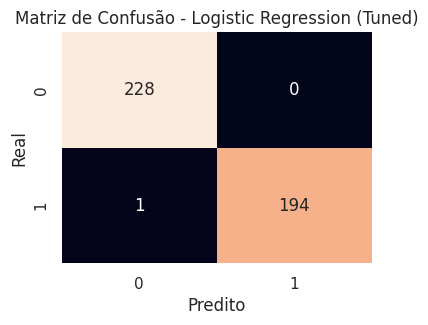

{'Model': 'Logistic Regression (Tuned)',
 'Accuracy': 0.9976359338061466,
 'Precision': 1.0,
 'Recall': 0.9948717948717949,
 'F1': 0.9974293059125964}

In [21]:
best_lr_model = grid.best_estimator_

best_lr_metrics = evaluate_model(best_lr_model, X_test, y_test, "Logistic Regression (Tuned)")
best_lr_metrics

## Salvamento do Pipeline Final

O pipeline final (pré-processamento + modelo) é salvo em arquivo `.joblib` para ser carregado
na aplicação preditiva (Streamlit).

In [23]:
Path("../models").mkdir(parents=True, exist_ok=True)
joblib.dump(best_lr_model, "../models/model.joblib")

print("Modelo salvo em: ../models/model.joblib")

Modelo salvo em: ../models/model.joblib
